Importando coisas

In [129]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

Declarando variáveis (que não tem valor definido no artigo)

In [130]:
T = 35
N2 = 0.25
N1 = 0.5
Z = 1
P1 = 1.5
P2 = 2

Declarando antecedentes e consequentes (universos)

In [131]:
bTime = ctrl.Antecedent(np.arange(0, 5*T, 1), 'Buffering time t (s)')
bTimeDiff = ctrl.Antecedent(np.arange(-T, 5*T, 1), 'Differential of the buffering time Δt (s)')
qualityDiff = ctrl.Consequent(np.arange(0, 2.5, 0.01), 'increase/reduce bitrate factor for next segment')

Montando membership functions + vendo resultados

C:\Users\theca\AppData\Local\Programs\Python\Python39\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\theca\AppData\Local\Programs\Python\Python39\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\theca\AppData\Local\Programs\Python\Python39\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


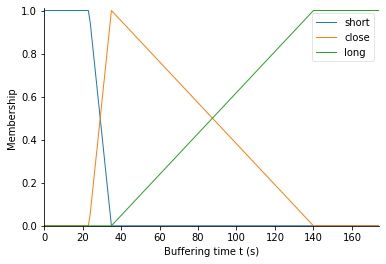

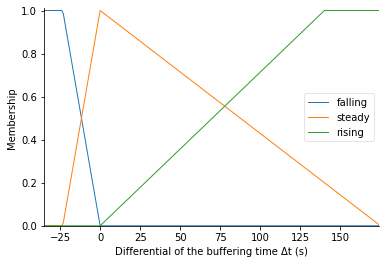

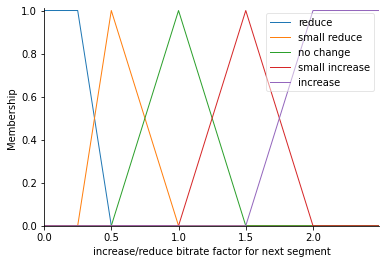

In [132]:
# Diferença entre tempo de buffering atual com um valor alvo T = 35s
bTime['short'] = fuzz.trapmf(bTime.universe, [0, 0, (2*T/3), T])
bTime['close'] = fuzz.trapmf(bTime.universe, [(2*T/3), T, T, 4*T])
bTime['long'] = fuzz.trapmf(bTime.universe, [T, 4*T, 5*T, 5*T])

# Comportamento da taxa de transferência entre tempos de buffering consecutivos
bTimeDiffUniverse = bTimeDiff.universe
bTimeDiff['falling'] = fuzz.trapmf(bTimeDiffUniverse, [-T, -T, (-2*T/3), 0])
bTimeDiff['steady'] = fuzz.trapmf(bTimeDiffUniverse, [(-2*T/3), 0, 0, 5*T])
bTimeDiff['rising'] = fuzz.trapmf(bTimeDiffUniverse, [0, 4*T, 5*T, 5*T])

# Fator de incremento/decremento da qualidade do próximo segmento
qualityDiffUniverse = qualityDiff.universe
qualityDiff['reduce'] = fuzz.trapmf(qualityDiffUniverse, [0, 0, N2, N1])
qualityDiff['small reduce'] = fuzz.trapmf(qualityDiffUniverse, [N2, N1, N1, Z])
qualityDiff['no change'] = fuzz.trapmf(qualityDiffUniverse, [N1, Z, Z, P1])
qualityDiff['small increase'] = fuzz.trapmf(qualityDiffUniverse, [Z, P1, P1, P2])
qualityDiff['increase'] = fuzz.trapmf(qualityDiffUniverse, [P1, P2, 2.5, 2.5])

bTime.view()
bTimeDiff.view()
qualityDiff.view()
# TODO verificar

Montando regras

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

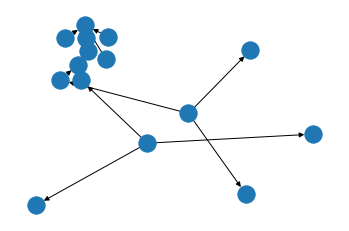

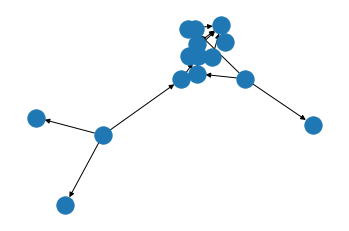

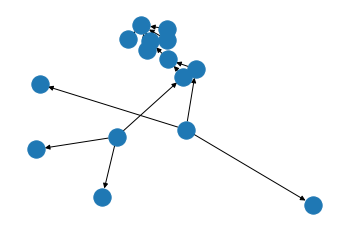

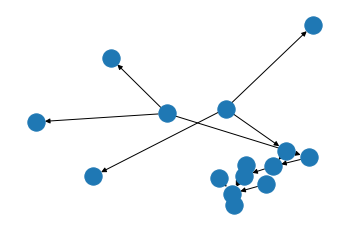

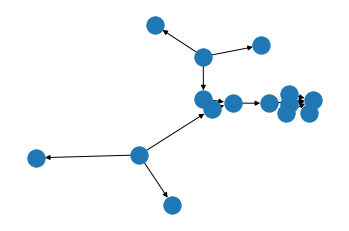

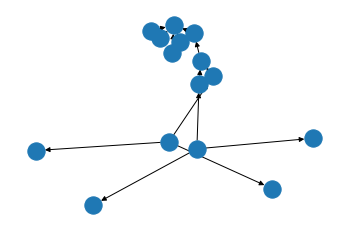

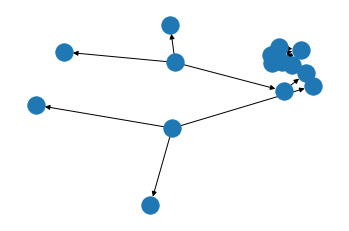

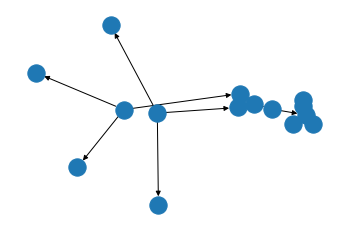

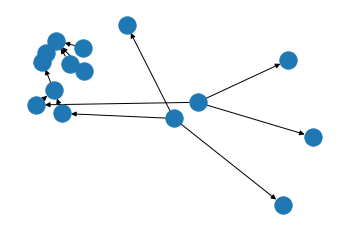

In [133]:
rule1 = ctrl.Rule(bTime['short'] & bTimeDiff['falling'], qualityDiff['reduce'])
rule2 = ctrl.Rule(bTime['close'] & bTimeDiff['falling'], qualityDiff['small reduce'])
rule3 = ctrl.Rule(bTime['long'] & bTimeDiff['falling'], qualityDiff['no change'])

rule4 = ctrl.Rule(bTime['short'] & bTimeDiff['steady'], qualityDiff['small reduce'])
rule5 = ctrl.Rule(bTime['close'] & bTimeDiff['steady'], qualityDiff['no change'])
rule6 = ctrl.Rule(bTime['long'] & bTimeDiff['steady'], qualityDiff['small increase'])

rule7 = ctrl.Rule(bTime['short'] & bTimeDiff['rising'], qualityDiff['no change'])
rule8 = ctrl.Rule(bTime['close'] & bTimeDiff['rising'], qualityDiff['small increase'])
rule9 = ctrl.Rule(bTime['long'] & bTimeDiff['rising'], qualityDiff['increase'])

# Falling
rule1.view()
rule2.view()
rule3.view()

# Steady
rule4.view()
rule5.view()
rule6.view()

# Rising
rule7.view()
rule8.view()
rule9.view()

# TODO completar

Declarando/Configurando o sistema de controle

In [134]:
FDASHControl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
FDASH = ctrl.ControlSystemSimulation(FDASHControl)

## Calculando saída/mostrando exemplo

Output: fator de acréscimo/decréscimo = 0.6872990255421431


C:\Users\theca\AppData\Local\Programs\Python\Python39\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


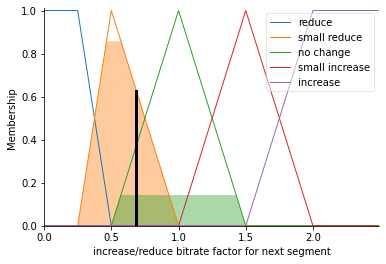

In [136]:
FDASH.input['Buffering time t (s)'] = 35
FDASH.input['Differential of the buffering time Δt (s)'] = -20

FDASH.compute()

output = FDASH.output['increase/reduce bitrate factor for next segment']
print("Output: fator de acréscimo/decréscimo =", output)
qualityDiff.view(sim=FDASH)